# Zonal Statistics

Author: [Lukas Valentin Graf](https://github.com/lukasValentin/lukasValentin) (2022-2023)

## Learning Objectives

In this notebook you will learn how to

* calculate zonal statistics for agricultural field parcels
* see how these statistics change over time

## Tutorial Content

This tutorial is introductorial level. 

Basic knowledge about [GeoPandas](https://geopandas.org/en/stable/) and EOdal might be helpful. If you are unfamiliar with EOdal you might check out [these notebooks](../General) first.

If you don't know about zonal statistics you might find reading [this blog](https://up42.com/blog/an-introduction-to-zonal-statistics) helpful.

To run this notebook no additional requirements in terms of software-setup are necessary. It connects, however, to [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/). No authentication is required but stable internet connection is an asset.

The data required to run this notebook can be found [here](./../data).

### Preparing the environment

In [1]:
!pip install scipy

In [2]:
import geopandas as gpd
import numpy as np

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from scipy.stats import median_abs_deviation

from pathlib import Path
from typing import List

Settings = get_settings()
# set to False to use a local data archove
Settings.USE_STAC = True

In [34]:
# check EOdal version
import eodal
print(f'The EOdal version is {eodal.__version__}')

The EOdal version is 0.2.0


### Defining custom metrics for zonal statistics

EOdal makes use of the [rasterstats](https://pythonhosted.org/rasterstats/) package to calculate zonal statistics. The cool thing about `rasterstats` is its ability to take custom functions as an input for calculating user-defined statistical metrics. This means, users will have a lot of freedom choicing the metrics most suited to their needs.

Below you find two examples of such custom functions. There are two important things to consider when writing user-defined functions:

1. the *function name* should be unique and not have the same name as any existing numpy function. Therefore, using a prefix such as `my_` might be helpful.
2. the *function should return a single scalar* as this is the definition of doing zonal statistics. *N* raster cells overlapping a geometry are aggregated by the function into a single value.

The two functions below calculate the `median absolute deviation` and the `sum of the square` of the raster cell values. This has no deeper meaning and is just to show how such custom functions should be designed.

In [3]:
def my_median_abs_deviation(x: np.ma.MaskedArray) -> float:
    """
    Custom function to calculate the median absolute
    deviation in `eodal.scene.get_feature_timeseries()`.

    :param x:
        array with raster values
    :returns:
        median absolute deviation value
    """
    x = x.filled(np.nan)
    return median_abs_deviation(x, nan_policy='omit', axis=None)

In [19]:
def my_square_sum(x: np.ma.MaskedArray) -> float:
    """
    Custom function returning sum(x**2)

    :param x:
        array with raster values
    :returns:
        median absolute deviation value
    """
    x = x.filled(np.nan)
    # important: the sum of nan is zero!
    if np.isnan(x).all():
        return np.nan
    return np.nansum(x*x)

### Getting the Sentinel-2 Data

This part of the notebook is essentially the same as in the [EOdal mapper notebook](../General/EOdal_Mapper.ipynb). We therefore don't repeat explainations here and recommened to have a look at the aforementioned notebook for details.

In [5]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
        interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True)
    return ds

In [6]:
#%% user-inputs
# -------------------------- Collection -------------------------------
collection: str = 'sentinel2-msi'

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2022,3,1)  		# year, month, day (incl.)
time_end: datetime = datetime(2022,5,1)   		# year, month, day (incl.)

# ---------------------- Spatial Feature  ------------------------------
geom: Path = Path('../../data/sample_polygons/ZH_Polygons_2020_ESCH_EPSG32632.shp')

# ------------------------- Metadata Filters ---------------------------
metadata_filters: List[Filter] = [
    Filter('cloudy_pixel_percentage','<', 80),
    Filter('processing_level', '==', 'Level-2A')
]

In [7]:
#%% query the scenes available (no I/O of scenes, this only fetches metadata)
feature = Feature.from_geoseries(gpd.read_file(geom).geometry)
mapper_configs = MapperConfigs(
    collection=collection,
    time_start=time_start,
    time_end=time_end,
    feature=feature,
    metadata_filters=metadata_filters
)
mapper_configs

EOdal MapperConfig
------------------
Collection: sentinel2-msi
Time Range: 2022-03-01 00:00:00 - 2022-05-01 00:00:00
Feature:
Name		geometry
Geometry	POLYGON ((477318.674545628 5255957.44910519, 477461.8062640463 5255880.593509117, 477450.87168848683 5255864.685411847, 477443.1052694199 5255855.242571056, 477302.4762257559 5255930.758590063, 477318.674545628 5255957.44910519))
EPSG Code	32632
Attributes	{}
Metadata Filters: [cloudy_pixel_percentage < 80, processing_level == Level-2A]

In [8]:
# now, a new Mapper instance is created
mapper = Mapper(mapper_configs)
mapper.query_scenes()
# the metadata is loaded into a GeoPandas GeoDataFrame
mapper.metadata

,product_uri,scene_id,spacecraft_name,tile_id,sensing_date,cloudy_pixel_percentage,epsg,sensing_time,sun_azimuth_angle,sun_zenith_angle,geom,assets
14,S2A_MSIL2A_20220305T102921_R108_T32TMT_2022030...,S2A_OPER_MSI_L2A_TL_ESRI_20220306T020615_A0349...,Sentinel-2A,32TMT,2022-03-05,1.280222,32632,2022-03-05 10:29:21.024,161.667769,54.956746,"POLYGON ((7.66287 47.84591, 9.13047 47.85363, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
13,S2B_MSIL2A_20220307T101759_R065_T32TMT_2022030...,S2B_OPER_MSI_L2A_TL_ESRI_20220308T005901_A0261...,Sentinel-2B,32TMT,2022-03-07,11.010902,32632,2022-03-07 10:17:59.024,158.604149,54.757018,"POLYGON ((7.74869 46.85849, 7.75737 46.88302, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
12,S2B_MSIL2A_20220310T102739_R108_T32TMT_2022031...,S2B_OPER_MSI_L2A_TL_ESRI_20220311T101831_A0261...,Sentinel-2B,32TMT,2022-03-10,0.632361,32632,2022-03-10 10:27:39.025,161.482896,52.994047,"POLYGON ((7.66287 47.84591, 9.13047 47.85363, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
11,S2B_MSIL2A_20220320T102639_R108_T32TMT_2022032...,S2B_OPER_MSI_L2A_TL_ESRI_20220321T005358_A0263...,Sentinel-2B,32TMT,2022-03-20,0.338798,32632,2022-03-20 10:26:39.024,161.262135,48.991058,"POLYGON ((7.66287 47.84591, 9.13047 47.85363, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
10,S2A_MSIL2A_20220322T101711_R065_T32TMT_2022032...,S2A_OPER_MSI_L2A_TL_ESRI_20220323T030838_A0352...,Sentinel-2A,32TMT,2022-03-22,1.812012,32632,2022-03-22 10:17:11.024,158.020749,48.773217,"POLYGON ((7.74718 46.85848, 7.76226 46.90118, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
9,S2A_MSIL2A_20220325T102651_R108_T32TMT_2022032...,S2A_OPER_MSI_L2A_TL_ESRI_20220325T235850_A0352...,Sentinel-2A,32TMT,2022-03-25,0.079917,32632,2022-03-25 10:26:51.024,161.201517,46.981061,"POLYGON ((7.66287 47.84591, 9.13047 47.85363, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
8,S2B_MSIL2A_20220327T101629_R065_T32TMT_2022032...,S2B_OPER_MSI_L2A_TL_ESRI_20220328T020908_A0264...,Sentinel-2B,32TMT,2022-03-27,1.837532,32632,2022-03-27 10:16:29.024,157.802681,46.782320,"POLYGON ((7.75253 46.85851, 7.80383 47.00126, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
7,S2A_MSIL2A_20220404T102601_R108_T32TMT_2022040...,S2A_OPER_MSI_L2A_TL_ESRI_20220404T222443_A0354...,Sentinel-2A,32TMT,2022-04-04,43.516320,32632,2022-04-04 10:26:01.024,161.009776,43.034004,"POLYGON ((7.66287 47.84591, 9.13047 47.85363, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
6,S2B_MSIL2A_20220406T101559_R065_T32TMT_2022040...,S2B_OPER_MSI_L2A_TL_ESRI_20220407T005151_A0265...,Sentinel-2B,32TMT,2022-04-06,29.913694,32632,2022-04-06 10:15:59.025,157.386954,42.869859,"POLYGON ((7.74970 46.85850, 7.80005 46.99889, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....
5,S2B_MSIL2A_20220409T102559_R108_T32TMT_2022041...,S2B_OPER_MSI_L2A_TL_ESRI_20220410T091212_A0265...,Sentinel-2B,32TMT,2022-04-09,71.353978,32632,2022-04-09 10:25:59.024,160.861845,41.124933,"POLYGON ((7.66287 47.84591, 9.13047 47.85363, ...",{'AOT': {'href': 'https://sentinel2l2a01.blob....


In [10]:
#%% load the scenes available from STAC
scene_kwargs = {
    'scene_constructor': Sentinel2.from_safe,
    'scene_constructor_kwargs': {'band_selection': ['B02', 'B03', 'B04', 'B08']},
    'scene_modifier': preprocess_sentinel2_scenes,
    'scene_modifier_kwargs': {'target_resolution': 10}
}
mapper.load_scenes(scene_kwargs=scene_kwargs)
scoll = mapper.data
scoll

2023-03-31 14:31:36,642 eodal        INFO     Starting extraction of sentinel2 scenes
2023-03-31 14:31:56,016 eodal        INFO     Finished extraction of sentinel2 scenes


EOdal SceneCollection
----------------------
# Scenes:    15
Timestamps:    2022-03-05 10:29:21, 2022-03-07 10:17:59, 2022-03-10 10:27:39, 2022-03-20 10:26:39, 2022-03-22 10:17:11, 2022-03-25 10:26:51, 2022-03-27 10:16:29, 2022-04-04 10:26:01, 2022-04-06 10:15:59, 2022-04-09 10:25:59, 2022-04-11 10:16:01, 2022-04-14 10:26:01, 2022-04-19 10:25:59, 2022-04-21 10:16:01, 2022-05-01 10:16:01
Scene Identifiers:    S2A_MSIL2A_20220305T102921_N0400_R108_T32TMT_20220306T020614.SAFE, S2B_MSIL2A_20220307T101759_N0400_R065_T32TMT_20220308T005859.SAFE, S2B_MSIL2A_20220310T102739_N0400_R108_T32TMT_20220311T101830.SAFE, S2B_MSIL2A_20220320T102639_N0400_R108_T32TMT_20220321T005356.SAFE, S2A_MSIL2A_20220322T101711_N0400_R065_T32TMT_20220323T030836.SAFE, S2A_MSIL2A_20220325T102651_N0400_R108_T32TMT_20220325T235848.SAFE, S2B_MSIL2A_20220327T101629_N0400_R065_T32TMT_20220328T020907.SAFE, S2A_MSIL2A_20220404T102601_N0400_R108_T32TMT_20220404T222441.SAFE, S2B_MSIL2A_20220406T101559_N0400_R065_T32TMT_2022040

### Calculationg zonal statistics

With the cells above we have loaded multiple scenes at once into a `SceneCollection`. We can now either calculate the zonal statistics per scene (which would be done using `RasterCollection.band_summaries()`) or make use of the `SceneCollection.get_feature_timeseries()` method that calls `RasterCollection.band_summaries()` for each scene and stacks the results into a single `GeoDataFrame`.

In the example below, we calculate two vegetation indices, namely the [NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) and the [MSAVI](https://eos.com/industries/agriculture/msavi/), and calculate zonal statistics per single field parcel and Sentinel-2 scene.

In [11]:
# calculate spectral indices
for _, scene in scoll:
    scene.calc_si('NDVI', inplace=True)
    scene.calc_si('MSAVI', inplace=True)

In [20]:
# get time series of the field parcel using a bunch of statistical metrics
ts = scoll.get_feature_timeseries(
    vector_features=geom,
    method=['percentile_10', 'percentile_50', 'median', 'mean', 'percentile_90', my_square_sum, my_median_abs_deviation],
    band_selection=['ndvi', 'msavi']
)
ts

/mnt/ides/Lukas/venvs/geo_notebooks/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 32N (the single non-null crs provided).
  warnings.warn(


,percentile_10,percentile_50,median,mean,percentile_90,my_square_sum,my_median_abs_deviation,GIS_ID,NUTZUNGSCO,NUTZUNG,geometry,band_name,acquisition_time
0,0.601058,0.682138,0.682138,0.674655,0.746230,22.457724,0.045558,24748,0513,Winterweizen ohne Futterweizen swissgranum,"POLYGON ((477318.675 5255957.449, 477461.806 5...",ndvi,2022-03-05 10:29:21
1,0.530281,0.530281,0.530281,0.530281,0.530281,0.281198,0.000000,32832,0613,Übrige Dauerwiesen (ohne Weiden),"MULTIPOLYGON (((477325.745 5255975.901, 477298...",ndvi,2022-03-05 10:29:21
2,0.742672,0.773386,0.773386,0.771569,0.802435,14.309157,0.014653,31448,0502,Wintergerste,"POLYGON ((477376.484 5255819.502, 477386.601 5...",ndvi,2022-03-05 10:29:21
3,0.571276,0.612358,0.612358,0.615501,0.661844,4.561506,0.022253,26950,0502,Wintergerste,"POLYGON ((477354.814 5255737.217, 477359.285 5...",ndvi,2022-03-05 10:29:21
4,0.513121,0.513121,0.513121,0.513121,0.513121,0.263293,0.000000,32829,0513,Winterweizen ohne Futterweizen swissgranum,"POLYGON ((477326.142 5255992.784, 477325.728 5...",ndvi,2022-03-05 10:29:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.654246,0.654246,0.654246,0.654246,0.654246,0.428038,0.000000,32832,0613,Übrige Dauerwiesen (ohne Weiden),"MULTIPOLYGON (((477325.745 5255975.901, 477298...",msavi,2022-05-01 10:16:01
8,0.802803,0.862528,0.862528,0.842220,0.873511,17.088790,0.011793,31448,0502,Wintergerste,"POLYGON ((477376.484 5255819.502, 477386.601 5...",msavi,2022-05-01 10:16:01
9,0.550848,0.748971,0.748971,0.714749,0.794924,6.237393,0.047486,26950,0502,Wintergerste,"POLYGON ((477354.814 5255737.217, 477359.285 5...",msavi,2022-05-01 10:16:01
10,0.721242,0.721242,0.721242,0.721242,0.721242,0.520191,0.000000,32829,0513,Winterweizen ohne Futterweizen swissgranum,"POLYGON ((477326.142 5255992.784, 477325.728 5...",msavi,2022-05-01 10:16:01


### Plotting Time Series

We can now plot time series values per field parcel using e.g., the median NDVI and MSAVI value per parcel and Sentinel-2 acquisition date.

In [24]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.8 MB/s eta 0:00:000:00:01


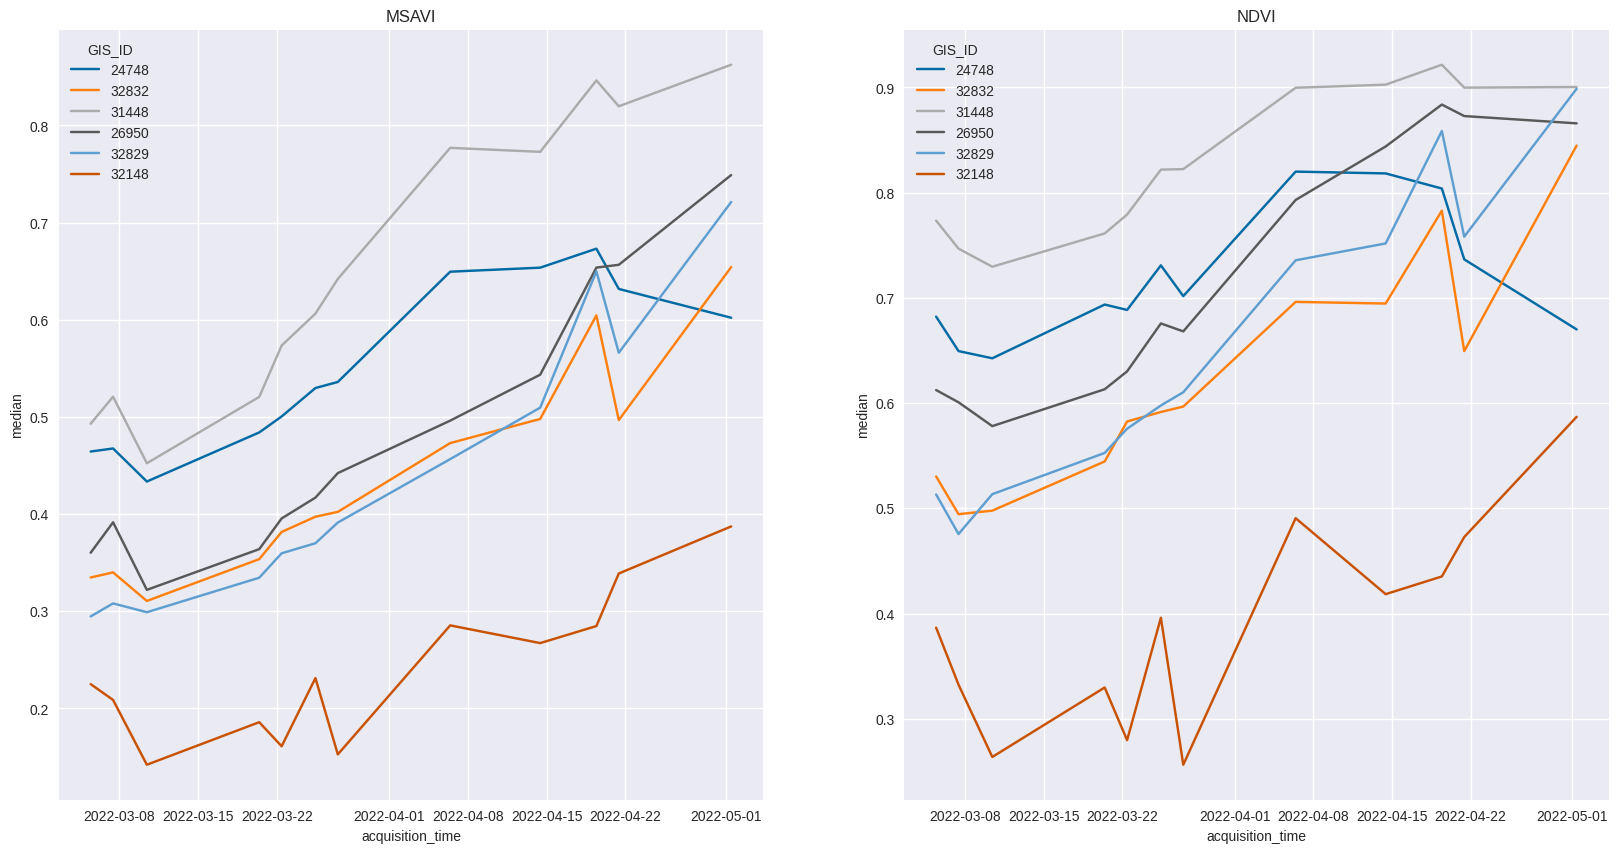

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')

# convert timestamps to get a nicely formatted x axis
ts.acquisition_time = pd.to_datetime(ts.acquisition_time)
f, ax = plt.subplots(ncols=2, figsize=(20,10))
ts_sis = ts.groupby(ts.band_name)

idx = 0
for si, ts_si in ts_sis:
    sns.lineplot(x='acquisition_time', y='median', hue='GIS_ID', data=ts_si, ax=ax[idx])
    ax[idx].set_title(si.upper())
    idx += 1

Since `ts` is a `GeoDataFrame` all results can be also visualized on a map or saved as, e.g., GeoPackage file for further analysis.

<Axes: >

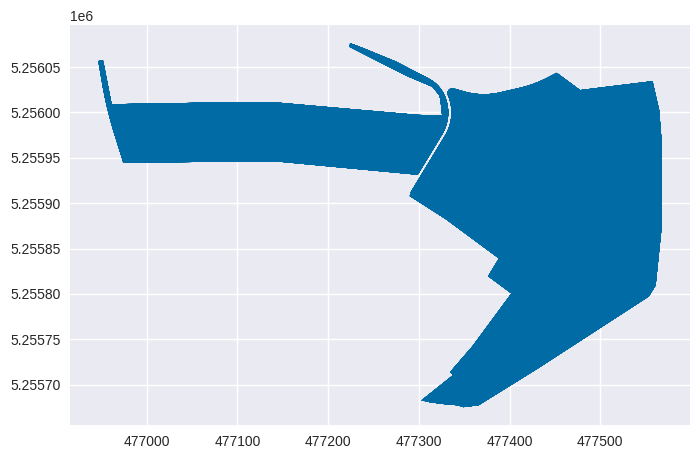

In [32]:
ts.plot()